Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import catboost
from sklearn.model_selection import train_test_split

Load datasets

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
df_train = df_train.fillna('ffill')
df_test = df_test.fillna('ffill')

Separate the labels from the features and remove columns we dont need

In [4]:
# separate labels from features
full_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
                       'TotalTimeStopped_p60','TotalTimeStopped_p80',
                       'TimeFromFirstStop_p20','TimeFromFirstStop_p40','TimeFromFirstStop_p50',
                       'TimeFromFirstStop_p60','TimeFromFirstStop_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p40','DistanceToFirstStop_p50',
                       'DistanceToFirstStop_p60','DistanceToFirstStop_p80']
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']


df_train_y = df_train[rel_training_label_cols]

# drop columns not needed
df_test_X = df_test.drop(columns=['RowId'])
df_train_X = df_train.drop(columns=['RowId']+full_training_label_cols)

In [5]:
print(df_train_X.dtypes)

categorical_features_indices = np.where(df_train_X.dtypes != float)[0]
X_train, X_validation, y_train, y_validation = train_test_split(df_train_X, df_train_y, train_size=0.75, random_state=42)

X_test = df_test_X

IntersectionId       int64
Latitude           float64
Longitude          float64
EntryStreetName     object
ExitStreetName      object
EntryHeading        object
ExitHeading         object
Hour                 int64
Weekend              int64
Month                int64
Path                object
City                object
dtype: object


In [7]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [8]:
models = []
for tc in rel_training_label_cols:

    model = CatBoostRegressor(
        loss_function='RMSE',
        iterations=200
    )

    model.fit(
        X_train, y_train[tc],
        cat_features=categorical_features_indices,
        eval_set=(X_validation, y_validation[tc]),
    #     logging_level='Verbose',  # you can uncomment this for text output
        plot=True
    )
    models.append(model)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.375043
0:	learn: 6.6172033	test: 6.5958383	best: 6.5958383 (0)	total: 311ms	remaining: 1m 1s
1:	learn: 6.3774106	test: 6.3140279	best: 6.3140279 (1)	total: 414ms	remaining: 41s
2:	learn: 6.2623297	test: 6.1781828	best: 6.1781828 (2)	total: 669ms	remaining: 43.9s
3:	learn: 6.2029722	test: 6.1106062	best: 6.1106062 (3)	total: 933ms	remaining: 45.7s
4:	learn: 6.1642681	test: 6.0698985	best: 6.0698985 (4)	total: 1.04s	remaining: 40.5s
5:	learn: 6.1312444	test: 6.0263169	best: 6.0263169 (5)	total: 1.35s	remaining: 43.7s
6:	learn: 6.1147472	test: 6.0017519	best: 6.0017519 (6)	total: 1.68s	remaining: 46.3s
7:	learn: 6.1019564	test: 5.9860181	best: 5.9860181 (7)	total: 1.78s	remaining: 42.9s
8:	learn: 6.0865317	test: 5.9702098	best: 5.9702098 (8)	total: 2.09s	remaining: 44.5s
9:	learn: 6.0765158	test: 5.9643836	best: 5.9643836 (9)	total: 2.24s	remaining: 42.6s
10:	learn: 6.0658378	test: 5.9522286	best: 5.9522286 (10)	total: 2.47s	remaining: 42.5s
11:	learn: 6.0616974	tes

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.375043
0:	learn: 13.7007794	test: 13.5122591	best: 13.5122591 (0)	total: 248ms	remaining: 49.3s
1:	learn: 12.7642356	test: 12.4565459	best: 12.4565459 (1)	total: 306ms	remaining: 30.3s
2:	learn: 12.3320992	test: 12.0123681	best: 12.0123681 (2)	total: 562ms	remaining: 36.9s
3:	learn: 12.1034547	test: 11.7345375	best: 11.7345375 (3)	total: 701ms	remaining: 34.4s
4:	learn: 11.9775350	test: 11.5838752	best: 11.5838752 (4)	total: 792ms	remaining: 30.9s
5:	learn: 11.8780950	test: 11.4959287	best: 11.4959287 (5)	total: 959ms	remaining: 31s
6:	learn: 11.8225030	test: 11.4283541	best: 11.4283541 (6)	total: 1.2s	remaining: 33.2s
7:	learn: 11.7730126	test: 11.3832343	best: 11.3832343 (7)	total: 1.42s	remaining: 34.1s
8:	learn: 11.7309406	test: 11.3440820	best: 11.3440820 (8)	total: 1.7s	remaining: 36s
9:	learn: 11.7000467	test: 11.3202876	best: 11.3202876 (9)	total: 1.95s	remaining: 37.1s
10:	learn: 11.6707022	test: 11.2823415	best: 11.2823415 (10)	total: 2.12s	remaining: 3

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.375043
0:	learn: 24.3692570	test: 23.7879586	best: 23.7879586 (0)	total: 278ms	remaining: 55.4s
1:	learn: 22.4827342	test: 21.6873221	best: 21.6873221 (1)	total: 361ms	remaining: 35.7s
2:	learn: 21.5797253	test: 20.7344858	best: 20.7344858 (2)	total: 414ms	remaining: 27.2s
3:	learn: 21.1204540	test: 20.2129390	best: 20.2129390 (3)	total: 508ms	remaining: 24.9s
4:	learn: 20.8466022	test: 19.9524597	best: 19.9524597 (4)	total: 660ms	remaining: 25.7s
5:	learn: 20.6727950	test: 19.7725119	best: 19.7725119 (5)	total: 908ms	remaining: 29.4s
6:	learn: 20.5341239	test: 19.6365759	best: 19.6365759 (6)	total: 1.2s	remaining: 33.1s
7:	learn: 20.4389078	test: 19.5765492	best: 19.5765492 (7)	total: 1.42s	remaining: 34.1s
8:	learn: 20.3621314	test: 19.5092100	best: 19.5092100 (8)	total: 1.49s	remaining: 31.6s
9:	learn: 20.3066840	test: 19.4692265	best: 19.4692265 (9)	total: 1.54s	remaining: 29.3s
10:	learn: 20.2448637	test: 19.4074530	best: 19.4074530 (10)	total: 1.68s	remaini

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.375043
0:	learn: 27.3663269	test: 28.9851270	best: 28.9851270 (0)	total: 254ms	remaining: 50.5s
1:	learn: 26.5618909	test: 28.1123452	best: 28.1123452 (1)	total: 339ms	remaining: 33.5s
2:	learn: 26.0972758	test: 27.5541251	best: 27.5541251 (2)	total: 468ms	remaining: 30.7s
3:	learn: 25.7969992	test: 27.2178840	best: 27.2178840 (3)	total: 755ms	remaining: 37s
4:	learn: 25.6227425	test: 27.0484952	best: 27.0484952 (4)	total: 1s	remaining: 39.2s
5:	learn: 25.4936065	test: 26.9164415	best: 26.9164415 (5)	total: 1.18s	remaining: 38.2s
6:	learn: 25.4086583	test: 26.8315988	best: 26.8315988 (6)	total: 1.39s	remaining: 38.4s
7:	learn: 25.3501902	test: 26.7664618	best: 26.7664618 (7)	total: 1.59s	remaining: 38.3s
8:	learn: 25.2909967	test: 26.7158974	best: 26.7158974 (8)	total: 1.84s	remaining: 39.2s
9:	learn: 25.2536728	test: 26.6783017	best: 26.6783017 (9)	total: 2.06s	remaining: 39.2s
10:	learn: 25.2197564	test: 26.6404917	best: 26.6404917 (10)	total: 2.37s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.375043
0:	learn: 68.5554520	test: 69.4103293	best: 69.4103293 (0)	total: 270ms	remaining: 53.8s
1:	learn: 65.2780034	test: 65.9812597	best: 65.9812597 (1)	total: 362ms	remaining: 35.9s
2:	learn: 63.5699850	test: 64.2681537	best: 64.2681537 (2)	total: 540ms	remaining: 35.4s
3:	learn: 62.5445921	test: 63.2488901	best: 63.2488901 (3)	total: 802ms	remaining: 39.3s
4:	learn: 61.8001982	test: 62.5517798	best: 62.5517798 (4)	total: 1.09s	remaining: 42.5s
5:	learn: 61.4384996	test: 62.1991945	best: 62.1991945 (5)	total: 1.27s	remaining: 41.1s
6:	learn: 60.6503580	test: 61.4796225	best: 61.4796225 (6)	total: 1.56s	remaining: 43s
7:	learn: 60.4727550	test: 61.3037458	best: 61.3037458 (7)	total: 1.62s	remaining: 38.9s
8:	learn: 60.2335078	test: 61.0997670	best: 61.0997670 (8)	total: 1.78s	remaining: 37.9s
9:	learn: 60.0633233	test: 60.9561758	best: 60.9561758 (9)	total: 2.03s	remaining: 38.6s
10:	learn: 59.7173957	test: 60.4429171	best: 60.4429171 (10)	total: 2.3s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.375043
0:	learn: 146.0737047	test: 146.1265186	best: 146.1265186 (0)	total: 294ms	remaining: 58.6s
1:	learn: 138.9879490	test: 138.3384238	best: 138.3384238 (1)	total: 541ms	remaining: 53.5s
2:	learn: 134.8712742	test: 133.9311584	best: 133.9311584 (2)	total: 815ms	remaining: 53.5s
3:	learn: 132.2346470	test: 131.2930481	best: 131.2930481 (3)	total: 1.04s	remaining: 51.1s
4:	learn: 130.6304317	test: 129.7424149	best: 129.7424149 (4)	total: 1.34s	remaining: 52.3s
5:	learn: 128.6349700	test: 127.4843998	best: 127.4843998 (5)	total: 1.52s	remaining: 49.1s
6:	learn: 127.2275188	test: 125.7692418	best: 125.7692418 (6)	total: 1.76s	remaining: 48.6s
7:	learn: 126.5524918	test: 125.2342987	best: 125.2342987 (7)	total: 1.94s	remaining: 46.4s
8:	learn: 126.0414056	test: 124.6341700	best: 124.6341700 (8)	total: 2.1s	remaining: 44.6s
9:	learn: 125.6027088	test: 123.9559811	best: 123.9559811 (9)	total: 2.34s	remaining: 44.4s
10:	learn: 125.2384037	test: 123.5546435	best: 123.

In [17]:
df = pd.read_csv('../submission/sample_submission.csv')

In [10]:

target_ids = df['TargetId'].values

for i,tid in enumerate(target_ids):
    target_ids[i] = tid.split('_')[0]

tids = np.sort(np.unique(target_ids).astype(int))
missing_ids = np.setdiff1d(df_test['RowId'].values,tids)
missing_ids_idxs = np.where(np.isin(df_test['RowId'].values,missing_ids))[0]

In [11]:
X_test_ = X_test.drop(missing_ids_idxs)

In [12]:
preds = []
for model in models:
    preds.append(model.predict(X_test_))

In [13]:
full_preds = np.zeros(len(preds)*len(preds[0]))
for i,pred in enumerate(preds):
    full_preds[i::6] = pred

In [19]:
df['Target'] = full_preds

In [20]:
df

,TargetId,Target
0,0_0,0.028469
1,0_1,1.924762
2,0_2,27.294148
3,0_3,-0.211675
4,0_4,7.417968
...,...,...
11522005,1920334_1,2.543647
11522006,1920334_2,7.999273
11522007,1920334_3,2.088298
11522008,1920334_4,11.893944


In [21]:
df.to_csv('../submission/cat_boost.csv',index=False)

Separate the Data by City

In [6]:
cities = ['Atlanta','Philadelphia','Boston','Chicago']
city_training_datasets_X = {}
city_training_datasets_y = {}
city_testing_datasets_X = {}

# training
for city in cities:
    # get rows for this city
    city_idxs = (df_train_X['City'] == city).values.nonzero()[0]

    # get X (data) and y (labels)
    city_training_datasets_X[city] = df_train_X.loc[city_idxs]
    city_training_datasets_y[city] = df_train_y.loc[city_idxs]

    # drop the city column from X (data)
    city_training_datasets_X[city] = city_training_datasets_X[city].drop(columns=['City'])

# testing
for city in cities:
    # get rows for this city
    city_idxs = (df_test_X['City'] == city).values.nonzero()[0]

    # get X (data)
    city_testing_datasets_X[city] = df_test_X.loc[city_idxs]

    # drop the city column from X (data)
    city_testing_datasets_X[city] = city_testing_datasets_X[city].drop(columns=['City'])

In [8]:
atl_train = city_training_datasets_X['Atlanta']
atl_test = city_testing_datasets_X['Atlanta']

In [19]:
print(f"train len: {len(atl_train)}\ntest len: {len(atl_test)}, ({len(atl_test)/len(atl_train)}x)")
train_int_ids = np.unique(atl_train['IntersectionId'])
test_int_ids = np.unique(atl_test['IntersectionId'])
print(f"{len(np.setdiff1d(test_int_ids,train_int_ids))} ({len(np.setdiff1d(test_int_ids,train_int_ids))/len(test_int_ids)} % are unseen)")

train len: 156484
test len: 341852, (2.184581171237954x)
125 (0.2670940170940171 % are unseen)


Feature Exploration
* Try to see if grouping cars by different characteristics shows any relationship with the the target values

**Go Straight**
* if the entry and exit street are the same (or the headings are the same), then we treat this as a car NOT making a turn. Intuitively cars that make turns may wait longer or take longer to go through the intersection than cars that go straight.

**Type of Turn**
* we can check left,right, and U turns using the entry and exit headings
* in general we have 8 headings: N,NE,E,SE,S,SW,W,NW which we can encode using 0-7
    * for each heading, a left turn would be the three numbers below, a right turn would be the three numbers above, and a U turn would be the number plus four

In [24]:
target_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']

# categorize turns
encoding = [0,1,2,3,4,5,6,7]
direction = ["N","NE","E","SE","S","SW","W","NW"]
left_turn = []
right_turn = []
u_turn = []
for e,d in zip(encoding,direction):
    for i in range(1,4):
        left_turn.append((d+'-'+direction[e-i]))
    for i in range(1,4):
        right_turn.append((d+'-'+direction[(e+i)%8]))
    u_turn.append((d+'-'+direction[(e+4)%8]))

# Check if a car went straight or not
# if it did not go straight, characterize the turn as right, left, or U-turn (0000, 0100, 0010, 0001)
turn_type_X = {}
straight_X_r2s = {city: {col: 0 for col in target_cols} for city in cities}
for city in cities:
    turn_type_X[city] = np.zeros((len(city_training_datasets_X[city]),4))

    # get entry/exit street names and headings
    entry_name = city_training_datasets_X[city]['EntryStreetName']
    exit_name = city_training_datasets_X[city]['ExitStreetName']
    entry_heading = city_training_datasets_X[city]['EntryHeading']
    exit_heading = city_training_datasets_X[city]['ExitHeading']

    # same street/heading --> straight (no turn)
    same_street_idxs = (entry_name==exit_name).values
    same_heading_idxs = (entry_heading==exit_heading).values
    straight_idxs = np.logical_or(same_street_idxs,same_heading_idxs)
    turn_type_X[city][straight_idxs][:] = 0

    # encode turn
    turn_enc = np.array([f'{x}-{y}' for x, y in zip(entry_heading, exit_heading)])

    # left turn
    left_idxs = np.zeros(len(entry_heading),dtype=int)
    for lt in left_turn:
        left_idxs[(turn_enc==lt).nonzero()[0]] = 1
    turn_type_X[city][left_idxs.nonzero()[0]] = np.array([0,1,0,0])

    # right turn
    right_idxs = np.zeros(len(entry_heading),dtype=int)
    for rt in right_turn:
        right_idxs[(turn_enc==rt).nonzero()[0]] = 1
    turn_type_X[city][right_idxs.nonzero()[0]] = np.array([0,0,1,0])

    # U-turn
    u_idxs = np.zeros(len(entry_heading),dtype=int)
    for ut in u_turn:
        u_idxs[(turn_enc==ut).nonzero()[0]] = 1
    turn_type_X[city][u_idxs.nonzero()[0]] = np.array([0,0,0,1])

    for target_col in target_cols:
        target = city_training_datasets_y[city][target_col].values
        model = LinearRegression()
        model.fit(turn_type_X[city],target)
        r2 = r2_score(target,model.predict(turn_type_X[city]))
        straight_X_r2s[city][target_col] = r2   

    # display distribution of turns per city
    print(f"City: {city}, no turn   : {np.all(turn_type_X[city] == np.array([0,0,0,0]),axis=1).mean()}")
    print(f"City: {city}, right turns: {np.all(turn_type_X[city] == np.array([0,1,0,0]),axis=1).mean()}")
    print(f"City: {city}, left turns:  {np.all(turn_type_X[city] == np.array([0,0,1,0]),axis=1).mean()}")
    print(f"City: {city}, u turns:     {np.all(turn_type_X[city] == np.array([0,0,0,1]),axis=1).mean()}")
    print()

City: Atlanta, no turn   : 0.5744996293550778
City: Atlanta, right turns: 0.21775389177168272
City: Atlanta, left turns:  0.20723524449784003
City: Atlanta, u turns:     0.0005112343753994018

City: Philadelphia, no turn   : 0.698936799944649
City: Philadelphia, right turns: 0.1484508132237589
City: Philadelphia, left turns:  0.15218444176231366
City: Philadelphia, u turns:     0.00042794506927841286

City: Boston, no turn   : 0.6469037101731638
City: Boston, right turns: 0.1821551140149034
City: Boston, left turns:  0.16881371873897782
City: Boston, u turns:     0.002127457072954982

City: Chicago, no turn   : 0.9117353051148807
City: Chicago, right turns: 0.047012949354821476
City: Chicago, left turns:  0.04112965379361918
City: Chicago, u turns:     0.0001220917366786469



Plot the r2 scores of the turning feature per city and per target variable
* Atlanta intersection wait times seem to have at least some connection to the turn type which aligns with the distribution of turns above. For example, almost all intersections in chicago were straight paths (no turns) so turning does not explain the wait time

In [32]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def plotting_func(results_dict):
    fig,ax = plt.subplots(1,len(cities),figsize=(12,3),sharey=True)
    for city_i,city in enumerate(cities):
        for target_i,target_col in enumerate(target_cols):
            if target_i == 0:
                ax[city_i].scatter(target_i,results_dict[city][target_col],c=colors[city_i],label=city)
            else:
                ax[city_i].scatter(target_i,results_dict[city][target_col],c=colors[city_i])
            ax[city_i].set_xticks(np.arange(6),target_cols,rotation=90)
        ax[city_i].axhline(0,c='k',linestyle='--')
        ax[city_i].set_yticks(np.linspace(-0.1,1,12))
        ax[city_i].grid()
        ax[city_i].legend()
    ax[0].set_ylabel("r2")
    ax[0].set_ylim([-0.1,1])

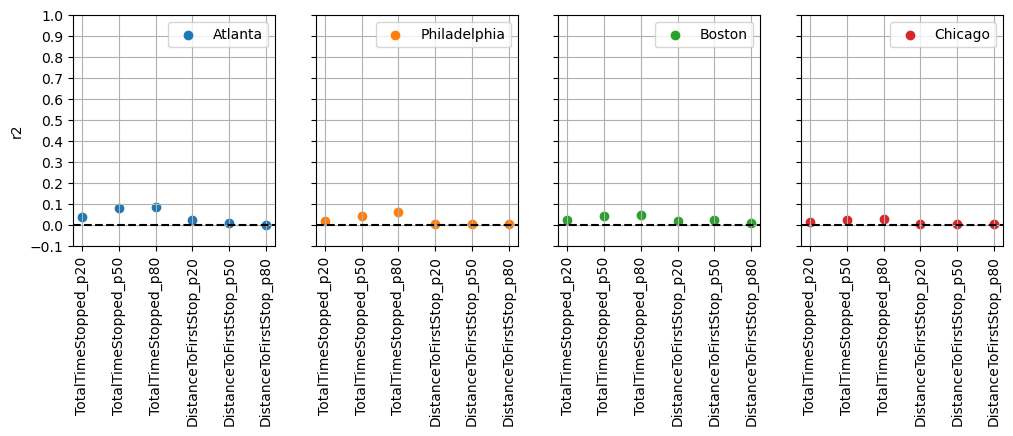

In [33]:
plotting_func(straight_X_r2s)

TODO
* next let's exlpore features related to space and time such as distance from the center of the city or time to the busiest time of day
* maybe we can try to cluster regions/times which have a lot of traffic and give each row a distance to the cluster
    * for example, if a new point is at the center of a busy cluster or a busy time it should have large wait time/distance

In [20]:
target_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']


# Get the k nearest neighbors based on l2
turn_type_X = {}
knn_X_r2s = {city: {col: 0 for col in target_cols} for city in cities}
for city in cities:
    for target_col in target_cols:
        target = city_training_datasets_y[city][target_col].values
        X = city_training_datasets_X[city][['Longitude','Latitude']]
        model = KNeighborsRegressor(n_neighbors=6)
        model.fit(X,target)
        r2 = r2_score(target,model.predict(X))
        knn_X_r2s[city][target_col] = r2 

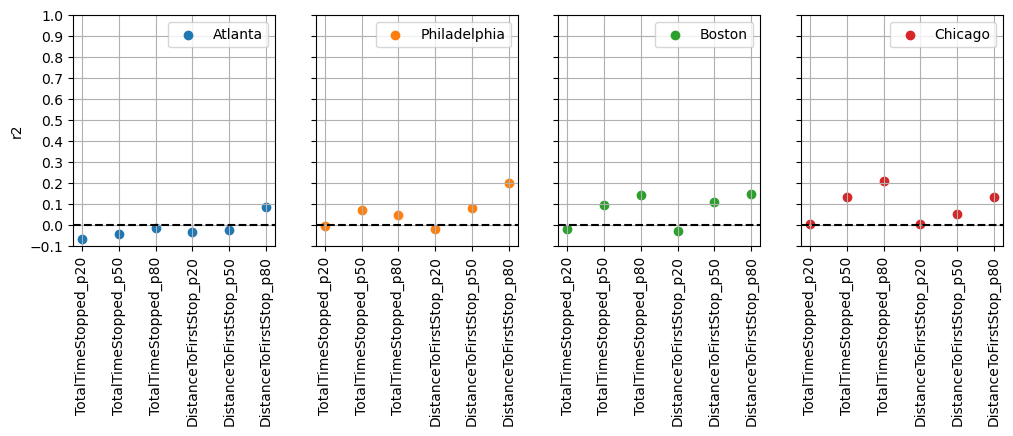

In [34]:
plotting_func(knn_X_r2s)